# Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor, as_completed
from matplotlib.patches import FancyBboxPatch
import matplotlib.gridspec as gridspec

import athena_utils as athena
import openia_script as ia

In [2]:
projects_id= 72

# Querys

In [3]:
def ejecutar_queries_paralelo(queries_dict, max_workers=5):
    """
    Ejecuta múltiples queries de Athena en paralelo.
    
    Args:
        queries_dict (dict): Diccionario donde la clave es el nombre identificador 
                            y el valor es la query SQL
                            Ejemplo: {'cancelaciones': query1, 'asistencias': query2}
        max_workers (int): Número máximo de threads paralelos (default: 5)
    
    Returns:
        dict: Diccionario con los DataFrames resultantes
              Ejemplo: {'cancelaciones': df1, 'asistencias': df2}
    """
    results = {}
    errors = {}
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Enviar todas las queries en paralelo
        futures = {
            executor.submit(athena.run_athena_query_auto, query, name): name 
            for name, query in queries_dict.items()
        }
        
        # Recoger resultados según vayan terminando
        for future in as_completed(futures):
            query_name = futures[future]
            try:
                df = future.result()
                results[query_name] = df
                print(f"✅ {query_name}: {len(df)} filas obtenidas")
            except Exception as e:
                errors[query_name] = str(e)
                print(f"❌ {query_name}: Error - {e}")
    
    # Reportar resumen
    print(f"\n📊 Resumen: {len(results)}/{len(queries_dict)} queries completadas exitosamente")
    
    if errors:
        print(f"⚠️  Queries con error: {list(errors.keys())}")
    
    return results

In [4]:
query_proyectos=f'''

SELECT 
    p.id AS proyecto_id,
    p.name AS proyecto_nombre,
    p.status AS estado,
    p.type AS tipo_canal,
    p.mode AS modalidad,
    p.operation_type AS tipo_operacion,
    p.complex_level AS nivel_complejidad,
    p.format AS formato,
    p.winning_date AS fecha_ganancia,
    p.operative_start_date AS fecha_inicio_operativo,
    p.operative_end_date AS fecha_fin_operativo,
    p.description AS descripcion,
    p.comment AS comentario,
    p.gender_focus AS enfoque_genero,
    ARRAY_JOIN(ARRAY_AGG(DISTINCT o.name), ', ') AS organizaciones,
    ARRAY_JOIN(ARRAY_AGG(DISTINCT o.organization_type), ', ') AS tipos_organizacion,
    ARRAY_JOIN(ARRAY_AGG(DISTINCT c.name), ', ') AS paises,
    ARRAY_JOIN(ARRAY_AGG(DISTINCT cbpt.name), ', ') AS tipos_programa
FROM 
    datalake.projects p
    LEFT JOIN datalake.project_organization_association poa ON p.id = poa.project_id
    LEFT JOIN datalake.organizations o ON poa.organization_id = o.id
    LEFT JOIN datalake.countries c ON o.country_id = c.id
    LEFT JOIN datalake.project_program_type_association ppta ON p.id = ppta.project_id
    LEFT JOIN datalake.catalog_b2bprogramtype cbpt ON ppta.program_type_id = cbpt.id
WHERE 
    p.id IN ({projects_id})
    
GROUP BY 
    p.id,
    p.name,
    p.status,
    p.type,
    p.mode,
    p.operation_type,
    p.complex_level,
    p.format,
    p.winning_date,
    p.operative_start_date,
    p.operative_end_date,
    p.seat_sold,
    p.description,
    p.comment,
    p.gender_focus
ORDER BY 
    p.id

'''

In [5]:
query_cancelaciones= f'''

WITH
cte_Organization AS (
    SELECT
        poa.project_id,
        ARRAY_JOIN(ARRAY_AGG(DISTINCT o.name), ', ') AS org_names
    FROM datalake.project_organization_association poa
    JOIN datalake.organizations o ON poa.organization_id = o.id
    GROUP BY poa.project_id
),
cte_ProgramType AS (
    SELECT
        ppta.project_id,
        ARRAY_JOIN(ARRAY_AGG(DISTINCT cbpt.name), ', ') AS program_types
    FROM datalake.project_program_type_association ppta
    JOIN datalake.catalog_b2bprogramtype cbpt ON ppta.program_type_id = cbpt.id
    GROUP BY ppta.project_id
),
base AS (
    SELECT
        DISTINCT
        p.id AS projectsID,
        p.name AS "Proyecto",
        COALESCE(p.type, 'B2C') AS "Canal",
        pt.program_types AS "Tipo de programa",
        o.org_names AS "Organización",
        (CASE WHEN ee.institution IS NULL THEN ei.name ELSE ee.institution END) AS institucion,
        (CASE WHEN ee.group_section IS NULL THEN rr.college_group ELSE ee.group_section END) AS seccion,
        ee.career AS career,
        rr.id AS room,
        rr.name AS "Room Name",
        CONCAT('https://backoffice.crackthecode.la/dashboard/rooms/', CAST(rr.id AS VARCHAR)) AS "Link Room",
        rs.id AS sesionID,
        rs.session_number AS sesion,
        ee.grade AS grado,
        (CASE WHEN rs.cancellation_reason_id IS NULL THEN 36 ELSE rs.cancellation_reason_id END) AS reasonID,
        (CASE WHEN rc.name IS NULL THEN 'N/A' ELSE rc.name END) AS Motivo,
        rs.start_date AS "Fecha",
        rs.start_time AS Hora,
        SUBSTR(rs.start_time, 1, 2) AS "Hora Agrupada",
        DATE_TRUNC('week', rs.start_date) AS ordenSemana,
        CONCAT(
            DATE_FORMAT(DATE_TRUNC('week', rs.start_date), '%d/%m'),
            '-',
            DATE_FORMAT(DATE_TRUNC('week', rs.start_date) + INTERVAL '6' DAY, '%d/%m')
        ) AS semana,
        DATE_FORMAT(rs.start_date, '%W') AS dia,
        rs.state AS state,
        rs.risk_cancellation AS Riesgo,
        CONCAT(au.last_name, ', ', au.first_name) AS profesor
    FROM
        datalake.room_roomsessions rs
        LEFT JOIN datalake.room_room rr ON rs.room_id = rr.id
        JOIN datalake.enrollment_enrolment ee ON rr.id = ee.room_id AND ee.b2b_project_id IS NOT NULL
        LEFT JOIN datalake.projects p ON (ee.b2b_project_id = p.id OR p.id = rr.project_b2b_id)
        LEFT JOIN cte_Organization o ON p.id = o.project_id
        LEFT JOIN cte_ProgramType pt ON p.id = pt.project_id
        LEFT JOIN datalake.account_user au ON rr.teacher_id = au.id
        LEFT JOIN datalake.catalog_reasonsessioncancellation rc ON (
            (CASE WHEN (rs.state = 'false' AND rs.cancellation_reason_id IS NULL) THEN 36 ELSE rs.cancellation_reason_id END) = rc.id
        )
        LEFT JOIN datalake.educational_institution ei ON ei.id = rr.educational_institution_id
    ORDER BY
        DATE_TRUNC('week', rs.start_date) ASC
)
SELECT *
FROM base
WHERE
    NOT (state = 'false' AND projectsID IN (19, 14) AND (("Fecha" BETWEEN DATE '2024-06-17' AND DATE '2024-07-05') OR ("Fecha" BETWEEN DATE '2024-10-07' AND DATE '2024-10-14')))
    AND
    NOT (state = 'false' AND projectsID IN (47, 48, 56) AND ("Fecha" BETWEEN DATE '2024-10-07' AND DATE '2024-10-14'))
    AND
    (reasonID NOT IN (33, 34, 35) OR reasonID IS NULL)
    
    and projectsID IN ({projects_id})
    
    ;


'''

In [6]:
query_asistencias=f'''

select distinct 
aa.id as attendance_id, 
aa.object_id, 
aa.content_type_id, 
CASE WHEN aa.content_type_id = 8 THEN 'Alumno' WHEN aa.content_type_id = 6 THEN 'Profesor CTC' when aa.content_type_id = 276 then 'Profesor IED' END as content_definition,
CASE WHEN aa.content_type_id = 8 THEN concat(ss.first_name,' ',ss.last_name) ELSE 'NO ES ALUMNO, ES PROFE' END as student_name,
ss.id as student_id,
ss.email as email_student,
ss.doc_type as tipo_documento,
ss.doc_number,
aa.room_id,
concat('https://backoffice.crackthecode.la/dashboard/rooms/', cast(aa.room_id as varchar)) link_room,
aa.room_session_id, 
rrs.start_date,
CASE 
    WHEN cast(aa.status as varchar) = '0' THEN '-'
    WHEN cast(aa.status as varchar) = '1' THEN 'A'
    WHEN cast(aa.status as varchar) = '2' THEN 'T'
    WHEN cast(aa.status as varchar) = '3' THEN 'F'
    WHEN cast(aa.status as varchar) = '4' THEN 'J'
    WHEN cast(aa.status as varchar) = '5' THEN 'R'
    WHEN cast(aa.status as varchar) = '6' THEN 'MR'
         WHEN cast(aa.status as varchar) = '7' THEN 'N/A'
    ELSE cast(aa.status as varchar)
END as attendance_status,
ee.institution, 
try_cast(ee.grade as integer) as grade, 
    CASE
        WHEN ee.state = 'abandoned' THEN 'Abandono'
        WHEN ee.state = 'cancel' THEN 'Cancelado'
        WHEN ee.state = 'done' THEN 'Activo'
        WHEN ee.state = 'inactive' THEN 'Inactivo'
        WHEN ee.state = 'risk' THEN 'En Riesgo'
        ELSE ee.state
    END AS state,
rr.name as room_name,
ee.b2b_project_id,
p.name,
rr.course_mdl_id

from datalake.attendance_attendance as aa 
left join datalake.enrollment_enrolment as ee on ee.room_id = aa.room_id and aa.object_id = ee.student_id
left join datalake.room_roomsessions as rrs on rrs.id = aa.room_session_id 
left join datalake.room_room as rr on rr.id = aa.room_id
left join datalake.student_student as ss on ss.id = aa.object_id
LEFT JOIN datalake.projects p ON (p.id = ee.b2b_project_id)

where 
    aa.content_type_id in (8,6) 
    and ee.b2b_project_id is not null


and rrs.start_date < current_date -- fecha desde donde nos enviaron la data retroactiva
and rrs.state = 'true'
and ee.state not in ('cancel', 'abandoned')

and ee.b2b_project_id IN ({projects_id})

'''

In [7]:
query_cuestionarios = f''' 

SELECT DISTINCT
     me.moodle_id moodle_user_id
   , 'Moodle' origen
   , ss.id student_id
   , ee.institution educative_institution
   , ee.grade grade
   , concat(ee.grade,'+', ee.group_section) grade_section
   , ee.career career
   , ee.educational_level educational_level
   , DATE_DIFF('year', ss.birthdate, p.operative_start_date) age 
   , ss.gender genero
   , p.id project_id
   , p.name project_name
   , ce.course_id moodle_course_id
   , rr.id room_id
   , ce.unique_id evaluation_unique_id
   , ce.name evaluation_name
   , ceq.name question_name
   , ceq.tag tag_question
   , ceq.question_id question_id
   , ceq.question_name question
   , cer.answer answer
   , cer.right_answer right_answer
   , ce.tag AS tipo_test

   FROM
   moodle_enrollment me
   LEFT JOIN moodle_course_evaluations ce ON (me.course_id = ce.course_id)
   LEFT JOIN moodle_course_evaluation_questions ceq ON (ce.unique_id = ceq.unique_id) AND ((ceq.question_name <> 'label') OR (ceq.question_name IS NULL))
   LEFT JOIN moodle_course_evaluation_responses cer ON ((cer.unique_id = ceq.unique_id) AND (ceq.question_id = cer.question_id) AND (me.moodle_id = cer.moodle_id) AND (ce.type <> 'assign')  AND (cer.attempt_time_finish IS NOT NULL))
   INNER JOIN room_room rr ON (rr.course_mdl_id = me.course_id)
   LEFT JOIN student_student ss ON (ss.user_mdl_id = me.moodle_id)
   LEFT JOIN room_room_students rrs ON ((rrs.student_id = ss.id) AND (rrs.room_id = rr.id))
   LEFT JOIN enrollment_enrolment ee ON (((ee.group_id = rr.group_id) OR (ee.room_id = rr.id)) AND (ee.student_id = ss.id) AND (ee.state <> 'cancel') AND (ee.state <> 'inactive'))
   LEFT JOIN projects p ON (p.id = ee.b2b_project_id)
   
   WHERE (p.id in ({projects_id}) and (me.role = 'student'))



'''

In [8]:
query_alumnos = f'''
select distinct
    p.id as project_id,
    p.name as proyecto,
    ss.id as ID, 
    concat(ss.last_name, ', ', ss.first_name) as Nombre_Completo,
    ss.email as Email,
    ss.phone_number as Telefono,
    ss.doc_type as tipo_documento,
    ss.doc_number as documento,
    ee.institution as Institucion,
    ee.grade as grado,
    ee.group_section as seccion,
    ee.room_id as Salon,
    case 
        when ss.gender='male' then 'Masculino'
        when ss.gender='female' then 'Femenino'
        else 'Indefinido' end as Genero,
    DATE_DIFF('year', ss.birthdate, p.operative_start_date) as Edad,
    case when ((ee.state <> 'cancel') and (ee.state <> 'inactive')) then 'Activo' else 'Inactivo' end as Status,
	COALESCE(MAX(CASE WHEN ceq.tag = 'estrato_socioeconomico' THEN cer.answer END), 'Sin respuesta') AS estrato_socioeconomico,
	COALESCE(ARRAY_JOIN(ARRAY_AGG(distinct CASE WHEN ceq.tag = 'etnia' THEN cer.answer END) FILTER (WHERE ceq.tag = 'etnia'), '|'), 'Sin respuesta') AS etnia,
    CASE 
        WHEN SUM(CASE WHEN device = 'Mobile' THEN 1 ELSE 0 END) = 0 THEN '1- Solo Desktop'
        WHEN SUM(CASE WHEN device = 'Desktop' THEN 1 ELSE 0 END) = 0 THEN '5- Solo Mobile'
        WHEN (SUM(CASE WHEN device = 'Desktop' THEN 1 ELSE 0 END) / CAST(COUNT(*) AS DOUBLE)) >= 0.8 THEN '2- 80% Desktop'
        WHEN (SUM(CASE WHEN device = 'Mobile' THEN 1 ELSE 0 END) / CAST(COUNT(*) AS DOUBLE)) >= 0.8 THEN '4- 80% Mobile'
        ELSE '3- Mixto'
        END AS dispositivo
	
from
    datalake.enrollment_enrolment ee
    left join datalake.student_student ss on ss.id=ee.student_id
    left join datalake.projects p on p.id=ee.b2b_project_id
	left join datalake.moodle_enrollment me on me.moodle_id=ss.user_mdl_id
	LEFT JOIN datalake.moodle_course_evaluations ce ON (me.course_id = ce.course_id)
   	LEFT JOIN datalake.moodle_course_evaluation_questions ceq ON (ce.unique_id = ceq.unique_id) AND ((ceq.question_name <> 'label') OR (ceq.question_name IS NULL))
   	LEFT JOIN datalake.moodle_course_evaluation_responses cer ON ((cer.unique_id = ceq.unique_id) AND (ceq.question_id = cer.question_id) AND (me.moodle_id = cer.moodle_id) AND (ce.type <> 'assign')  AND (cer.attempt_time_finish IS NOT NULL))
    LEFT JOIN datalake.moodle_session_device msd ON msd.userid=ss.user_mdl_id and msd.ip is not null

where
    p.id in ({projects_id})
    and ee.state='done'

group by
	p.id,
    p.name,
    ss.id,
    ss.last_name,
    ss.first_name,
    ss.email,
    ss.phone_number,
    ss.doc_type,
    ss.doc_number,
    ee.institution,
    ee.grade,
    ee.group_section,
    ee.room_id,
    ss.gender,
    ss.birthdate,
    p.operative_start_date,
    ee.state
'''

In [9]:
# Preparar queries
queries = {
    'cancelaciones': query_cancelaciones,
    'asistencias': query_asistencias,
    # 'cuestionarios': query_cuestionarios,
    'alumnos': query_alumnos,
    'proyectos': query_proyectos
}

# Ejecutar en paralelo
print("🚀 Iniciando ejecución de queries en paralelo...\n")
dataframes = ejecutar_queries_paralelo(queries)

2025-10-24 08:20:39,716 - INFO - Found credentials in shared credentials file: ~/.aws/credentials
2025-10-24 08:20:39,716 - INFO - Found credentials in shared credentials file: ~/.aws/credentials
2025-10-24 08:20:39,716 - INFO - Found credentials in shared credentials file: ~/.aws/credentials
2025-10-24 08:20:39,716 - INFO - Found credentials in shared credentials file: ~/.aws/credentials


🚀 Iniciando ejecución de queries en paralelo...

✅ proyectos: 1 filas obtenidas
✅ cancelaciones: 8972 filas obtenidas
✅ asistencias: 181131 filas obtenidas
✅ alumnos: 7993 filas obtenidas

📊 Resumen: 4/4 queries completadas exitosamente


In [56]:
# Acceder a los resultados
df_cancelaciones = dataframes.get('cancelaciones')
df_asistencias = dataframes.get('asistencias')
# df_cuestionarios = dataframes.get('cuestionarios')
df_alumnos=dataframes.get('alumnos')
df_proyectos=dataframes.get('proyectos')

## Funciones

In [416]:
def truncar_texto(texto, max_chars=25):
    """Acorta texto largo agregando '...' """
    texto_str = str(texto)
    if len(texto_str) > max_chars:
        return texto_str[:max_chars-3] + '...'
    return texto_str

In [417]:
def crear_grafico_distribucion(
    df_distribucion,
    col_categoria,
    col_cantidad,
    titulo_grafico,
    label_y,
    colormap='Blues'
    ):
    """
    Crea un gráfico de distribución con barras horizontales.
    """
    # Invertir para mostrar de arriba a abajo
    dist_invertido = df_distribucion.iloc[::-1].copy()
    
    # Crear figura con tamaño optimizado para solo gráfico
    fig, ax = plt.subplots(figsize=(10, 5))
    
    n_categorias = len(dist_invertido)
    
    # Manejar colores
    if isinstance(colormap, list):
        colores = colormap[:n_categorias]
    else:
        colores = plt.colormaps[colormap](np.linspace(0.4, 0.9, n_categorias))
    
    # Crear barras horizontales
    bars = ax.barh(
        dist_invertido[col_categoria], 
        dist_invertido[col_cantidad],
        color=colores,
        edgecolor='white',
        linewidth=2.5
    )
    
    # Agregar etiquetas con cantidad y porcentaje
    for bar, cantidad in zip(bars, dist_invertido[col_cantidad]):
        porcentaje = (cantidad / dist_invertido[col_cantidad].sum()) * 100
        ax.text(
            cantidad + (dist_invertido[col_cantidad].max() * 0.02),
            bar.get_y() + bar.get_height()/2,
            f'{cantidad} ({porcentaje:.1f}%)',
            va='center',
            fontsize=11,
            weight='bold',
            color='#2E3F5F'
        )
    
    # Estilo del gráfico
    ax.set_ylabel(label_y, fontsize=11, weight='bold', color='#2E3F5F')
    ax.set_title(titulo_grafico, fontsize=14, weight='bold', pad=20, color='#2E3F5F')
    
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    ax.tick_params(axis='y', colors='#2E3F5F', labelsize=10)
    ax.set_xlim(0, dist_invertido[col_cantidad].max() * 1.18)
    
    plt.tight_layout()
    
    return fig

In [418]:
def crear_top_n_con_otros(df, columna_categoria, columna_valor, n=10, nombre_otros='Otros'):
    """
    Crea un top N agrupando el resto como 'Otros'
    
    Parámetros:
    -----------
    df : DataFrame ya agrupado y ordenado
    columna_categoria : str - nombre de la columna de categorías
    columna_valor : str - nombre de la columna de valores
    n : int - número de elementos en el top
    nombre_otros : str - etiqueta para agrupar el resto
    
    Returns:
    --------
    DataFrame con top N + fila de Otros
    """
    top_n = df.head(n).copy()
    resto = df.iloc[n:]
    
    if len(resto) > 0:
        fila_otros = pd.DataFrame({
            columna_categoria: [nombre_otros],
            columna_valor: [resto[columna_valor].sum()]
        })
        resultado = pd.concat([top_n, fila_otros], ignore_index=True)
    else:
        resultado = top_n
    
    return resultado

In [419]:
biblioteca = {}

# Caracteristicas del proyecto
- Agregar una query mas que traiga toda la informacion del proyecto

In [420]:
resumen_proyecto = (
    df_alumnos.groupby(['project_id', 'proyecto'])
    .agg(
        Activos=('id', 'nunique'),
        Instituciones=('institucion', 'nunique'),
        age_min=('edad', 'min'),
        age_max=('edad', 'max'),
        Salones=('salon', 'nunique'),
        Mujeres=('id', lambda x: df_alumnos.loc[x.index][df_alumnos.loc[x.index, 'genero'] == 'Femenino']['id'].nunique()),
        Hombres=('id', lambda x: df_alumnos.loc[x.index][df_alumnos.loc[x.index, 'genero'] == 'Masculino']['id'].nunique()),
    )
    .reset_index()
)

# Calcular el porcentaje de respuestas por tipo de test
resumen_proyecto['Rango de edad']= resumen_proyecto['age_min'].astype(str)  + ' a ' + resumen_proyecto['age_max'].astype(str) + ' años'
resumen_proyecto['% Mujeres']=round(resumen_proyecto['Mujeres'] / resumen_proyecto['Activos'] * 100, 1)
resumen_proyecto['% Hombres']=round(resumen_proyecto['Hombres'] / resumen_proyecto['Activos'] * 100, 1)

resumen_proyecto.drop(columns=['age_min', 'age_max', 'project_id'], inplace=True)
resumen_proyecto.rename(columns={'proyecto': 'Proyecto'}, inplace=True)

biblioteca['proyecto'] = {
    'name': 'Resumen del proyecto',
    'df': resumen_proyecto
}

resumen_proyecto.head()

,Proyecto,Activos,Instituciones,Salones,Mujeres,Hombres,Rango de edad,% Mujeres,% Hombres
0,+Educación+Innovación 2025,7984,28,245,4758,3155,6 a 24 años,59.6,39.5


In [421]:
if df_alumnos['institucion'].nunique()>0:
    resumen_IE = (
        df_alumnos.groupby(['institucion'])
        .agg(
            Activos=('id', 'nunique'),
            Mujeres=('id', lambda x: df_alumnos.loc[x.index][df_alumnos.loc[x.index, 'genero'] == 'Femenino']['id'].nunique()),
            Hombres=('id', lambda x: df_alumnos.loc[x.index][df_alumnos.loc[x.index, 'genero'] == 'Masculino']['id'].nunique()),
        )
        .reset_index()
    )

    # Calcular el porcentaje de respuestas por tipo de test
    resumen_IE['% Mujeres']=round(resumen_IE['Mujeres'] / resumen_IE['Activos'] * 100, 1)
    resumen_IE['% Hombres']=round(resumen_IE['Hombres'] / resumen_IE['Activos'] * 100, 1)
    resumen_IE.rename(columns={'institucion': 'Institución'}, inplace=True)

    biblioteca['instituciones'] = {
        'name': 'Resumen por instituciones',
        'df': resumen_IE
    }

    resumen_IE.head()

In [422]:
if df_alumnos['grado'].nunique()>0:

    resumen_grado = (
        df_alumnos.groupby(['grado'])
        .agg(
            Activos=('id', 'nunique'),
            Mujeres=('id', lambda x: df_alumnos.loc[x.index][df_alumnos.loc[x.index, 'genero'] == 'Femenino']['id'].nunique()),
            Hombres=('id', lambda x: df_alumnos.loc[x.index][df_alumnos.loc[x.index, 'genero'] == 'Masculino']['id'].nunique()),
        )
        .reset_index()
    )

    # Calcular el porcentaje de respuestas por tipo de test
    resumen_grado['% Mujeres']=round(resumen_grado['Mujeres'] / resumen_grado['Activos'] * 100, 1)
    resumen_grado['% Hombres']=round(resumen_grado['Hombres'] / resumen_grado['Activos'] * 100, 1)
    resumen_grado.rename(columns={'grado': 'Grado'}, inplace=True)

    try:
        resumen_grado['Grado']=resumen_grado['Grado'].astype(int)
    except:
        pass

    resumen_grado.sort_values('Grado', ascending=True, inplace=True)

    biblioteca['grado'] = {
    'name': 'Resumen por grado',
    'df': resumen_grado
    }

    resumen_grado.head()

# Análisis de Distribuciones Demográficas

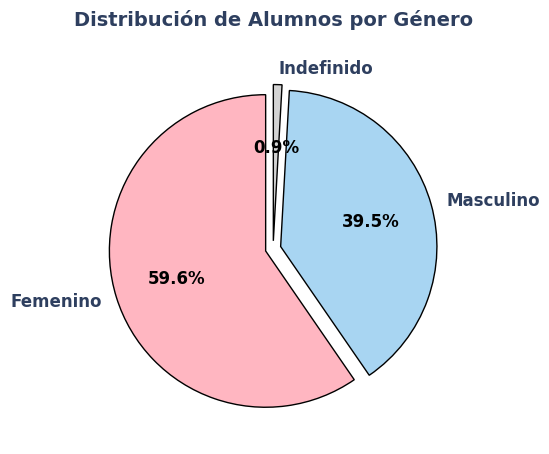

In [423]:
# 1. DISTRIBUCIÓN POR GÉNERO
dist_genero = df_alumnos.groupby('genero')['id'].nunique().reset_index().sort_values('id', ascending=False)
dist_genero.columns = ['Género', 'Estudiantes']
dist_genero['% del total'] = (dist_genero['Estudiantes'] / dist_genero['Estudiantes'].sum() * 100).round(1)


# Crear figura con dos subplots (gráfico + tabla)
fig_genero = plt.figure(figsize=(10, 5), constrained_layout=True)
gs = fig_genero.add_gridspec(1, 2, width_ratios=[1, 1], wspace=0.3)

# --- SUBPLOT 1: Gráfico de Torta ---
ax_pie = fig_genero.add_subplot(gs[0])


# Mapeo de colores específicos por género
color_map = {
    'Masculino': '#A8D5F2',  # Azul pastel
    'Femenino': '#FFB6C1',   # Rosa pastel
    'Indefinido': '#D3D3D3'  # Gris
}

# Asignar colores según el género en el DataFrame
colores = [color_map.get(genero, '#CCCCCC') for genero in dist_genero['Género']]
explode = [0.05] * len(dist_genero)  # Crear lista con 0.05 para cada categoría

wedges, texts, autotexts = ax_pie.pie(
    dist_genero['Estudiantes'],
    labels=dist_genero['Género'],
    autopct='%1.1f%%',
    startangle=90,
    colors=colores,
    explode=explode,
    shadow=False,
    textprops={'fontsize': 11, 'weight': 'bold'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True}
)

# Estilo de los porcentajes (blancos sobre el gráfico)
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(12)
    autotext.set_weight('bold')

# Estilo de las etiquetas
for text in texts:
    text.set_fontsize(12)
    text.set_weight('bold')
    text.set_color('#2E3F5F')

ax_pie.set_title('Distribución de Alumnos por Género', 
                 fontsize=14, weight='bold', pad=20, color='#2E3F5F')


plt.show()

biblioteca['genero'] = {
    'name': 'distribucion_por_genero',
    'fig': fig_genero,
    'df': dist_genero
}

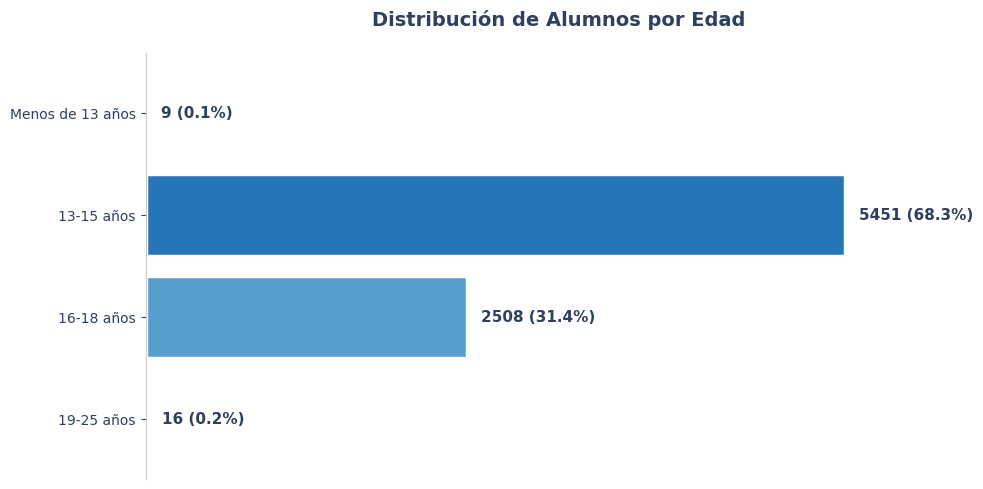

In [424]:
# 2. DISTRIBUCIÓN POR RANGO DE EDAD
def categorizar_edad(edad):
    if pd.isna(edad):
        return 'Sin información'
    elif 13 <= edad <= 15:
        return '13-15 años'
    elif 16 <= edad <= 18:
        return '16-18 años'
    elif 19 <= edad <= 25:
        return '19-25 años'
    elif 26 <= edad <= 30:
        return '26-30 años'
    elif 31 <= edad <= 40:
        return '31-40 años'
    elif 41 <= edad <= 50:
        return '41-50 años'
    elif 51 <= edad <= 60:
        return '51-60 años'
    elif edad >= 61:
        return '61+ años'
    else:
        return 'Menos de 13 años'

df_alumnos['rango_edad'] = df_alumnos['edad'].apply(categorizar_edad)


dist_edad = df_alumnos.groupby('rango_edad')['id'].nunique().reset_index()
dist_edad.columns = ['Rango de Edad', 'Estudiantes']
dist_edad['% del total'] = (dist_edad['Estudiantes'] / dist_edad['Estudiantes'].sum() * 100).round(1)

# Ordenar por rango
orden_edad = ['Menos de 13 años', '13-15 años', '16-18 años', '19-25 años', '26-30 años', '31-40 años', '41-50 años', '51-60 años', '61+ años', 'Sin información']
dist_edad['Rango de Edad'] = pd.Categorical(dist_edad['Rango de Edad'], categories=orden_edad, ordered=True)
dist_edad = dist_edad.sort_values('Rango de Edad')

# 1. Distribución por Edad
fig_edad = crear_grafico_distribucion(
    df_distribucion=dist_edad,
    col_categoria='Rango de Edad',
    col_cantidad='Estudiantes',
    titulo_grafico='Distribución de Alumnos por Edad',
    label_y='',
    colormap= 'Blues'

)

biblioteca['edad'] = {
    'name': 'distribucion_por_rango_etario',
    'fig': fig_edad,
    'df': dist_edad
}

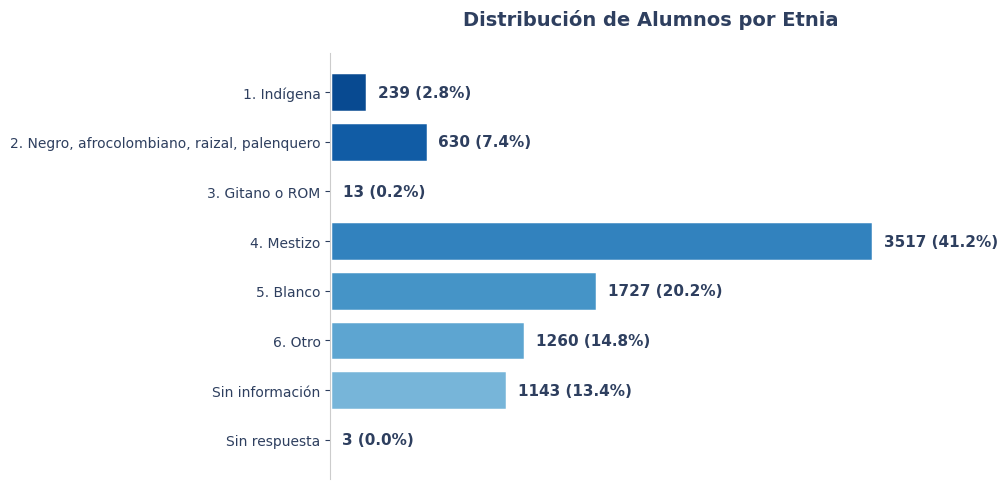

In [425]:
# 4. DISTRIBUCIÓN POR ETNIA/ASCENDENCIA
# Desagregar etnias concatenadas (separadas por |)
def desagregar_etnias(df, columna_etnia='etnia'):
    """
    Desagrega etnias cuando un estudiante tiene múltiples valores separados por |
    """
    # Lista para almacenar los registros desagregados
    registros_desagregados = []
    
    for idx, row in df.iterrows():
        etnia_valor = row[columna_etnia]
        
        # Si el valor es nulo o vacío
        if pd.isna(etnia_valor) or str(etnia_valor).strip() == '':
            registros_desagregados.append({
                'id': row['id'],
                'etnia_individual': 'Sin información'
            })
        else:
            # Separar por | y crear un registro por cada etnia
            etnias = str(etnia_valor).split(';')
            for etnia in etnias:
                etnia_limpia = etnia.strip()
                if etnia_limpia:  # Solo si no está vacío
                    registros_desagregados.append({
                        'id': row['id'],
                        'etnia_individual': etnia_limpia
                    })
    
    return pd.DataFrame(registros_desagregados)

# Desagregar las etnias
df_etnias_desagregadas = desagregar_etnias(df_alumnos)

# Calcular distribución
dist_etnia = df_etnias_desagregadas.groupby('etnia_individual')['id'].nunique().reset_index()
dist_etnia.columns = ['Etnia/Ascendencia', 'Identificadas']
dist_etnia=dist_etnia.sort_values('Etnia/Ascendencia')

# Calcular porcentaje sobre el total de estudiantes únicos
total_estudiantes = df_alumnos['id'].nunique()
dist_etnia['% del total'] = (dist_etnia['Identificadas'] / total_estudiantes * 100).round(1)

# grafico
fig_etnia = crear_grafico_distribucion(
    df_distribucion=dist_etnia,
    col_categoria='Etnia/Ascendencia',
    col_cantidad='Identificadas',
    titulo_grafico='Distribución de Alumnos por Etnia',
    label_y='',
    colormap='Blues')

biblioteca['etnia'] = {
    'name': 'distribucion_por_etnia',
    'fig': fig_etnia,
    'df': dist_etnia
}

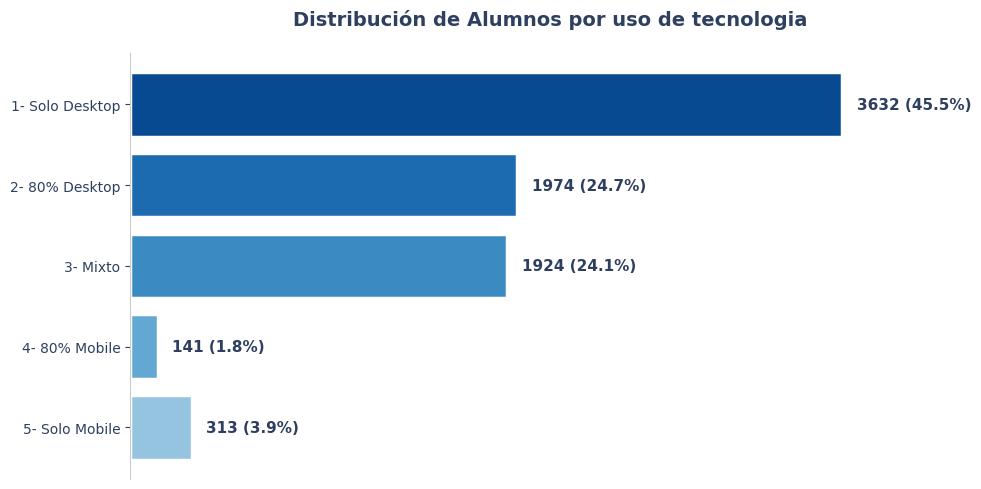

In [426]:
dist_dispositivo=df_alumnos.groupby('dispositivo')['id'].nunique().reset_index()
dist_dispositivo.columns =  ['Dispositivo', 'Estudiantes']
dist_dispositivo['% del total'] = (dist_dispositivo['Estudiantes'] / dist_dispositivo['Estudiantes'].sum()*100).round(2)
dist_dispositivo=dist_dispositivo.sort_values('Dispositivo')

fig_dispositivo = crear_grafico_distribucion(
    df_distribucion=dist_dispositivo,
    col_categoria='Dispositivo',
    col_cantidad='Estudiantes',
    titulo_grafico='Distribución de Alumnos por uso de tecnologia',
    label_y='',
    colormap='Blues'
)

biblioteca['dispositivo'] = {
    'name': 'distribucion_por_dispositivo',
    'fig': fig_dispositivo,
    'df': dist_dispositivo
}

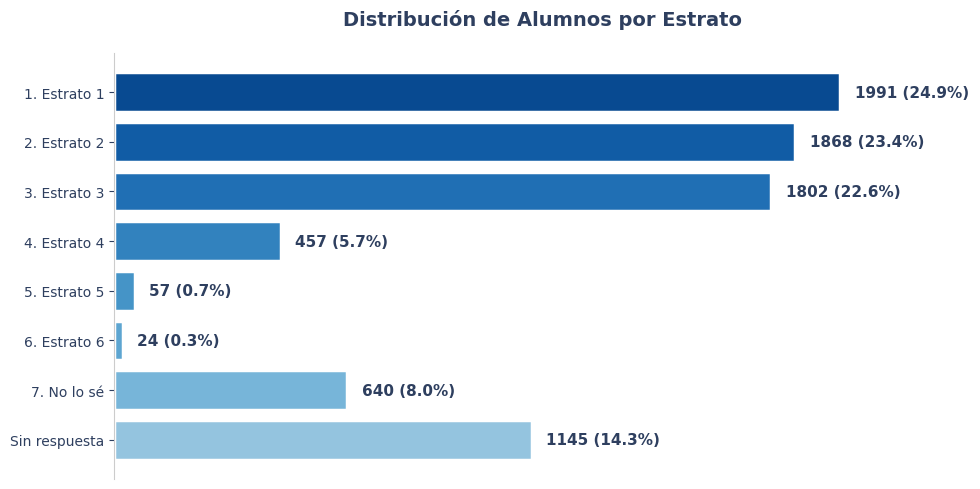

In [427]:
# 3. DISTRIBUCIÓN POR ESTRATO SOCIOECONÓMICO
dist_estrato = df_alumnos.groupby('estrato_socioeconomico')['id'].nunique().reset_index()
dist_estrato.columns = ['Estrato', 'Estudiantes']
dist_estrato['Porcentaje'] = (dist_estrato['Estudiantes'] / dist_estrato['Estudiantes'].sum() * 100).round(1)
dist_estrato = dist_estrato.sort_values('Estrato')

fig_estrato = crear_grafico_distribucion(
    df_distribucion=dist_estrato,
    col_categoria='Estrato',
    col_cantidad='Estudiantes',
    titulo_grafico='Distribución de Alumnos por Estrato',
    label_y='',
    colormap='Blues')

biblioteca['estrato'] = {
    'name': 'Distribucion por estrato economico',
    'fig': fig_estrato,
    'df': dist_estrato
}

# Analisis de asistencia

## Funciones

In [428]:
def crear_grafico_cards(datos_cards, titulo_general="Dashboard de Métricas", 
                        filas=1, columnas=None, figsize=None):
    """
    Crea un gráfico con múltiples cards de información.
    
    Parámetros:
    -----------
    datos_cards : list of dict
        Lista de diccionarios con la información de cada card.
        Cada diccionario debe tener:
        - 'titulo': str - Título de la card
        - 'valor': float o str - Valor principal a mostrar
        - 'subtitulo': str (opcional) - Texto debajo del valor
        - 'sufijo': str (opcional) - Sufijo para el valor (ej: '%', 'hrs', etc.)
    
    titulo_general : str
        Título general del gráfico
    
    filas : int
        Número de filas para organizar las cards
    
    columnas : int (opcional)
        Número de columnas. Si no se especifica, se calcula automáticamente
    
    figsize : tuple (opcional)
        Tamaño de la figura (ancho, alto)
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        La figura creada
    
    Ejemplo de uso:
    ---------------
    datos = [
        {'titulo': 'Asistencia General', 'valor': 85.5, 'sufijo': '%', 
         'subtitulo': 'Promedio mensual'},
        {'titulo': 'Horas Trabajadas', 'valor': 160, 'sufijo': ' hrs', 
         'subtitulo': 'Este mes'},
        {'titulo': 'Proyectos Activos', 'valor': 12, 
         'subtitulo': 'En desarrollo'}
    ]
    fig = crear_grafico_cards(datos)
    plt.show()
    """
    
    num_cards = len(datos_cards)
    
    # Calcular columnas automáticamente si no se especifica
    if columnas is None:
        columnas = min(3, num_cards)  # Máximo 3 columnas
        filas = (num_cards + columnas - 1) // columnas
    
    # Calcular figsize automáticamente si no se especifica
    if figsize is None:
        ancho = columnas * 5
        alto = filas * 3.5
        figsize = (ancho, alto)
    
    # Crear figura
    fig = plt.figure(figsize=figsize)
    fig.suptitle(titulo_general, fontsize=16, weight='bold', y=0.98)
    
    # Crear grid
    gs = gridspec.GridSpec(filas, columnas, figure=fig, 
                          hspace=0.4, wspace=0.3,
                          left=0.08, right=0.92, top=0.92, bottom=0.08)
    
    # Crear cada card
    for idx, card_data in enumerate(datos_cards):
        fila = idx // columnas
        col = idx % columnas
        
        ax = fig.add_subplot(gs[fila, col])
        ax.axis('off')
        
        # Extraer datos de la card
        titulo = card_data.get('titulo', 'Sin título')
        valor = card_data.get('valor', 0)
        subtitulo = card_data.get('subtitulo', '')
        sufijo = card_data.get('sufijo', '')
        
        # Crear tarjeta con bordes redondeados
        card = FancyBboxPatch(
            (0.05, 0.1), 0.9, 0.8,
            boxstyle="round,pad=0.05",
            facecolor='#E3F2FD',      # Azul muy claro de fondo
            edgecolor='#1565C0',       # Azul oscuro para borde
            linewidth=2.5,
            transform=ax.transAxes,
            zorder=1
        )
        ax.add_patch(card)
        
        # Título de la tarjeta
        ax.text(
            0.5, 0.75,
            titulo,
            ha='center',
            va='center',
            fontsize=12,
            weight='bold',
            color='#0D47A1',          # Azul oscuro
            transform=ax.transAxes,
            wrap=True
        )
        
        # Valor principal (NEGRO)
        valor_texto = f'{valor}{sufijo}' if isinstance(valor, (int, float)) else str(valor)
        
        # Ajustar tamaño de fuente según longitud del texto
        if len(valor_texto) > 8:
            fontsize_valor = 32
        elif len(valor_texto) > 6:
            fontsize_valor = 38
        else:
            fontsize_valor = 44
        
        ax.text(
            0.5, 0.45,
            valor_texto,
            ha='center',
            va='center',
            fontsize=fontsize_valor,
            weight='bold',
            color='black',            # COLOR NEGRO para el porcentaje/valor
            transform=ax.transAxes
        )
        
        # Subtítulo (si existe)
        if subtitulo:
            ax.text(
                0.5, 0.2,
                subtitulo,
                ha='center',
                va='center',
                fontsize=9,
                color='#424242',      # Gris oscuro
                transform=ax.transAxes,
                style='italic'
            )
        
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
    
    return fig

In [ ]:
def asistencia_por(df: dataframes, agrupacion: str):

    # Calcular % de asistencias por proyecto
    asistencias_por = (
        df.groupby(agrupacion)
        .apply(lambda grupo: pd.Series({
            'Total_registros': grupo['attendance_id'].nunique(),
            'Asistencias': grupo[grupo['attendance_status'].isin(['A', 'T', 'J'])]['attendance_id'].nunique(),
            'Faltas': grupo[~grupo['attendance_status'].isin(['A', 'T', 'J'])]['attendance_id'].nunique()
        }), include_groups=False)
        .reset_index()
    )

    asistencias_por['% Asistencia'] = round(
        (asistencias_por['Asistencias'] / asistencias_por['Total_registros']) * 100, 1
    )

    asistencias_por['% Falta'] = round(
        (asistencias_por['Faltas'] / asistencias_por['Total_registros']) * 100, 1
    )

    asistencias_por.drop(columns=['Faltas', 'Asistencias', 'Total_registros'], inplace=True)

    # Agregar a la biblioteca
    biblioteca['asistencias_proyecto'] = {
        'name': 'Porcentaje de asistencias por proyecto',
        'df': asistencias_por
    }

    return asistencias_por

In [430]:
def grafico_columnas_asistencia(df: dataframes, guardar: str, titulo_grafico: str, 
                                xlabel: str = 'Mes', ylabel: str = '% Asistencia'):
    """
    Crea un gráfico de columnas con la asistencia mensual en formato profesional.
    
    Parámetros:
    -----------
    df : dataframes
        DataFrame con los datos de asistencia
    guardar : str
        Clave para guardar en la biblioteca
    titulo_grafico : str
        Título principal del gráfico
    xlabel : str
        Etiqueta del eje X (por defecto 'Mes')
    ylabel : str
        Etiqueta del eje Y (por defecto '% Asistencia')
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
    """
    
    # Obtener datos de asistencia por mes
    asistencia_mes = asistencia_por(df, 'mes').sort_values('mes')
    
    # Crear figura
    fig, ax = plt.subplots(figsize=(12, 6))
    fig.patch.set_facecolor('white')
    
    # Configurar colores profesionales en tonos azules
    n_categorias = len(asistencia_mes)
    colores = plt.colormaps['Blues'](np.linspace(0.4, 0.9, n_categorias))
    
    # Crear gráfico de barras
    bars = ax.bar(
        asistencia_mes['mes'],
        asistencia_mes['% Asistencia'],
        color=colores,
        edgecolor='#1565C0',
        linewidth=1.5,
        alpha=0.9,
        width=0.7
    )
    
    # Agregar etiquetas sobre las barras con valores
    for bar, porcentaje in zip(bars, asistencia_mes['% Asistencia']):
        altura = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            altura + 1.2,
            f'{porcentaje:.1f}%',
            ha='center',
            va='bottom',
            fontsize=11,
            weight='bold',
            color='#0D47A1'
        )
    
    # Título principal
    ax.set_title(
        titulo_grafico,
        fontsize=16,
        weight='bold',
        pad=20,
        color='#1565C0'
    )
    
    # Etiquetas de ejes
    ax.set_xlabel(xlabel, fontsize=12, weight='bold', color='#424242', labelpad=10)
    ax.set_ylabel(ylabel, fontsize=12, weight='bold', color='#424242', labelpad=10)
    
    # Grilla sutil para facilitar la lectura
    ax.grid(axis='y', alpha=0.25, linestyle='--', linewidth=0.8, color='#BBDEFB')
    ax.set_axisbelow(True)
    
    # Estilo de los bordes (spines)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#90CAF9')
    ax.spines['bottom'].set_color('#90CAF9')
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    
    # Estilo de los ticks
    ax.tick_params(
        axis='x',
        colors='#424242',
        labelsize=10,
        rotation=45,
        length=5,
        width=1.5
    )
    ax.tick_params(
        axis='y',
        colors='#424242',
        labelsize=10,
        length=5,
        width=1.5
    )
    ax.set_yticks([])
    
    # Ajustar límites del eje Y para mejor visualización
    ax.set_ylim(0, 108)


    
    # Ajustar layout para que no se corten las etiquetas
    plt.tight_layout()
    
    # Guardar en biblioteca
    biblioteca[f'asistencia_{guardar}'] = {
        'name': 'grafico_columnas_asistencia',
        'fig': fig,
        'df': asistencia_mes
    }
    
    return fig


## Analisis

In [431]:
promedio_alumnos_asistentes_por_salon=int(
    df_asistencias[df_asistencias['attendance_status']=='A']
    .groupby('room_id')['student_id']
    .nunique()
    .mean()
    )

In [432]:
df_asistencias['start_date'] = pd.to_datetime(df_asistencias['start_date'])
df_asistencias['mes'] = df_asistencias['start_date'].dt.to_period('M').astype(str)
df_asistencia_profe = df_asistencias[df_asistencias['content_definition'] == 'Profesor CTC'].copy()
df_asistencia_alumno = df_asistencias[df_asistencias['content_definition'] == 'Alumno'].copy()

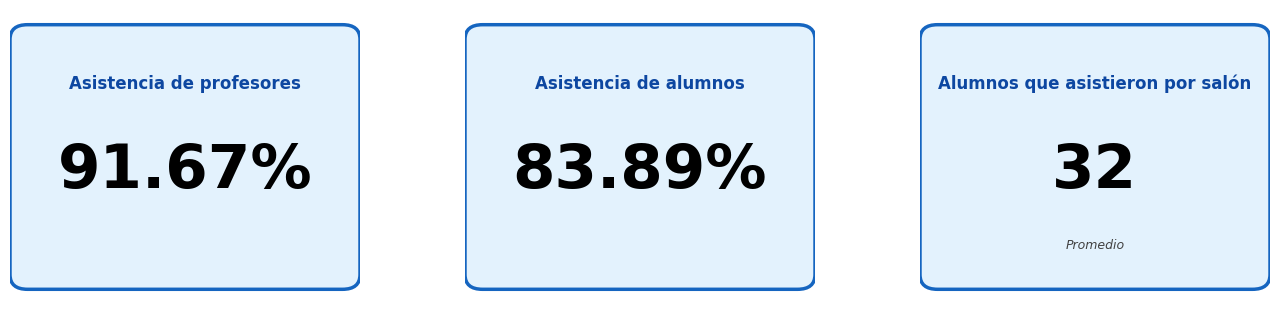

In [433]:
datos_asistencia = [
    {
        'titulo': 'Asistencia de profesores',
        'valor': asistencia_por(df_asistencia_profe, 'name')['% Asistencia'][0],
        'sufijo': '%'
    },
    {
        'titulo': 'Asistencia de alumnos',
        'valor': asistencia_por(df_asistencia_alumno, 'name')['% Asistencia'][0],
        'sufijo': '%'
    },
    {
        'titulo': 'Alumnos que asistieron por salón',
        'valor': promedio_alumnos_asistentes_por_salon,
        'subtitulo': 'Promedio'
    }
]

fig_tarjetas_asistencias= crear_grafico_cards(datos_asistencia, titulo_general="")
plt.show()

2025-10-24 10:27:06,063 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-24 10:27:06,063 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


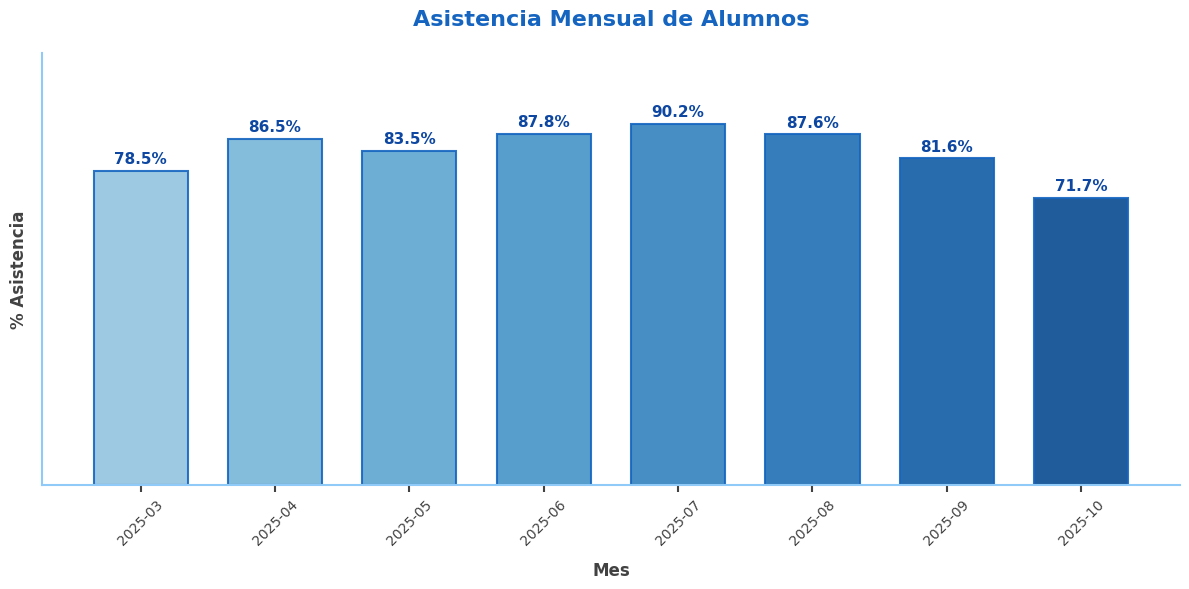

In [434]:
fig_asistencia_alumno= grafico_columnas_asistencia(
    df=df_asistencia_alumno,
    guardar='alumno',
    titulo_grafico='Asistencia Mensual de Alumnos'
)

2025-10-24 10:27:06,290 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-24 10:27:06,290 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


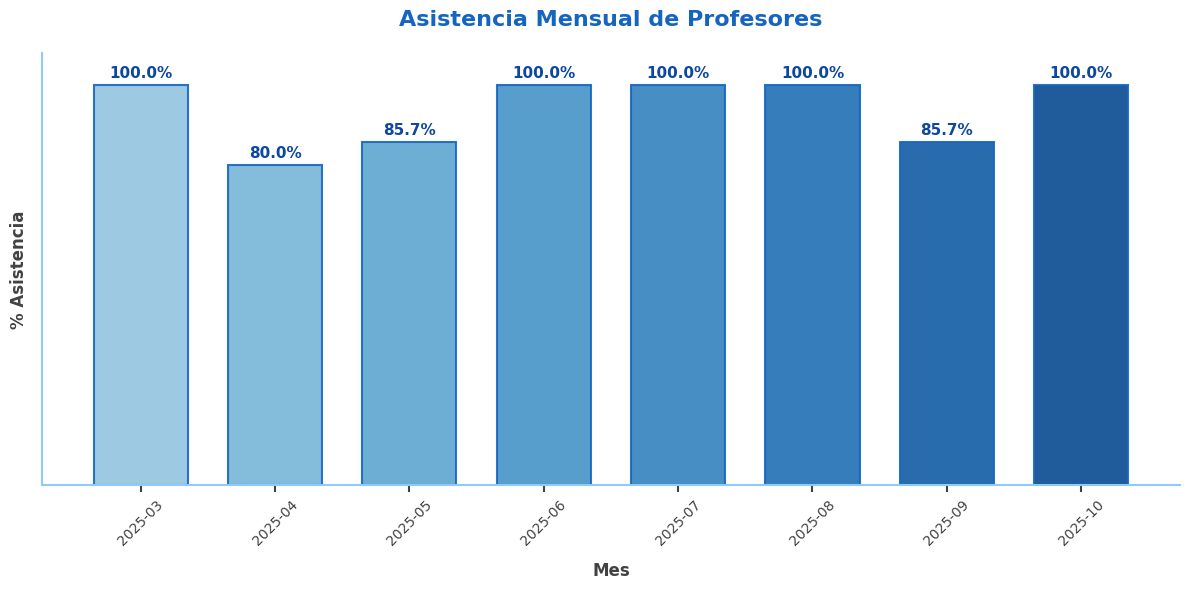

In [435]:
fig_asistencia_profe= grafico_columnas_asistencia(
    df=df_asistencia_profe,
    guardar='profesor',
    titulo_grafico='Asistencia Mensual de Profesores'
)

# Cancelaciones

In [436]:
df_cancelaciones.columns

Index(['projectsid', 'proyecto', 'canal', 'tipo de programa', 'organización',
       'institucion', 'seccion', 'career', 'room', 'room name', 'link room',
       'sesionid', 'sesion', 'grado', 'reasonid', 'motivo', 'fecha', 'hora',
       'hora agrupada', 'ordensemana', 'semana', 'dia', 'state', 'riesgo',
       'profesor'],
      dtype='object')

In [446]:
## --- TARJETAS GENERALES DE CANCELACIONES --- ## 
sesiones_canceladas=df_cancelaciones[df_cancelaciones['state']=='false']['sesionid'].nunique()
sesiones_programadas=df_cancelaciones['sesionid'].nunique()
porcentaje_cancelacion=round((sesiones_canceladas / sesiones_programadas)*100,2)
porcentaje_dictado=round(100-porcentaje_cancelacion,2)

## -- RESUMEN POR PROYECTO DE CANCELACIONES -- ##
resumen_cancelaciones_por_proyecto=df_cancelaciones.groupby('projectsid').agg(
    sesiones_programadas=('sesionid', 'nunique'),
    sesiones_canceladas=('sesionid', lambda x: df_cancelaciones.loc[x.index][df_cancelaciones.loc[x.index, 'state'] == 'false']['sesionid'].nunique())
)

resumen_cancelaciones_por_proyecto['% Cancelación']=round(
    resumen_cancelaciones_por_proyecto['sesiones_canceladas'] 
    / resumen_cancelaciones_por_proyecto['sesiones_programadas'] * 100,2)

resumen_cancelaciones_por_proyecto['% Dictado']=round(100-resumen_cancelaciones_por_proyecto['% Cancelación'],2)

resumen_cancelaciones_por_proyecto.rename(columns={'sesiones_programadas':'Sesiones programadas', 'sesiones_canceladas':'Sesiones canceladas'}, inplace=True)
## -- MOTIVOS DE CANCELACIONES -- ## 

resumen_motivos_cancalaciones=(
    df_cancelaciones[df_cancelaciones['state']=='false']
    .groupby('motivo')
    .agg(
        sesiones_canceladas=('sesionid', 'nunique')
    )
    ).sort_values('sesiones_canceladas', ascending=False
    ).reset_index()

resumen_motivos_cancalaciones['% Cancelación']=round(
    resumen_motivos_cancalaciones['sesiones_canceladas'] 
    / sesiones_canceladas * 100,1)
    
resumen_motivos_cancalaciones.rename(columns={'motivo':'Motivo', 'sesiones_canceladas': 'Sesiones canceladas'}, inplace=True)

## -- CANCELACIONES POR IE -- ## 

resumen_cancelaciones_IE=(
    df_cancelaciones[df_cancelaciones['state']=='false']
    .groupby('institucion')
    .agg(
        sesiones_canceladas=('sesionid', 'nunique')
    )
    ).sort_values('sesiones_canceladas', ascending=False
    ).reset_index()
    
resumen_cancelaciones_IE['% Cancelación']=round(
    resumen_cancelaciones_IE['sesiones_canceladas'] 
    / sesiones_canceladas * 100,1)
    
resumen_cancelaciones_IE.rename(columns={'institucion':'Institución', 'sesiones_canceladas': 'Sesiones canceladas'}, inplace=True)

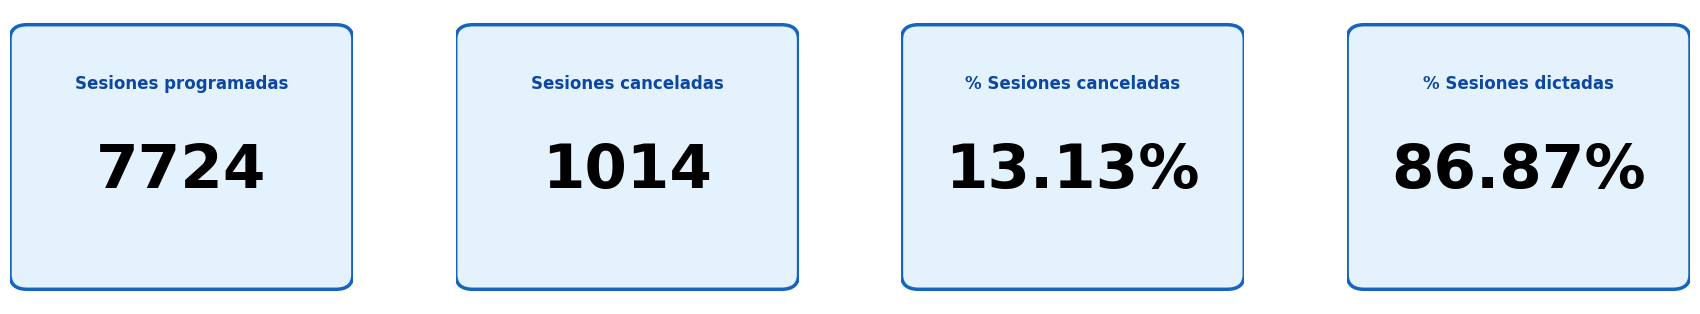

In [438]:
datos_cancelaciones = [
    {
        'titulo': 'Sesiones programadas',
        'valor': sesiones_programadas,
    },
    {
        'titulo': 'Sesiones canceladas',
        'valor': sesiones_canceladas
    },
    {
        'titulo': '% Sesiones canceladas',
        'valor': porcentaje_cancelacion,
        'sufijo': '%'
    },
    {
        'titulo': '% Sesiones dictadas',
        'valor': porcentaje_dictado,
        'sufijo': '%'
    }
]

fig_tarjetas_cancelaciones= crear_grafico_cards(datos_cancelaciones, titulo_general="", filas=1, columnas=4)
plt.show()

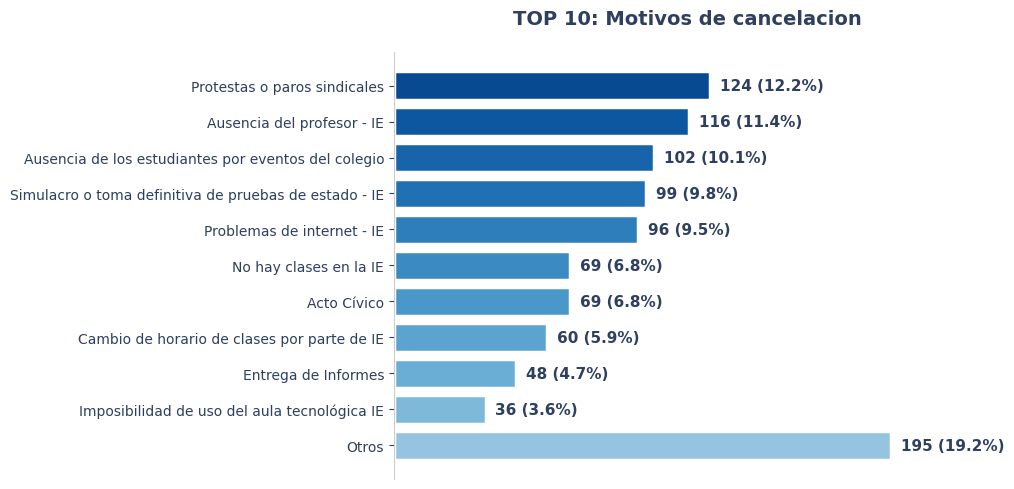

In [447]:
top_10_motivos_cancelacion=crear_top_n_con_otros(
    df=resumen_motivos_cancalaciones,
    columna_categoria='Motivo',
    columna_valor='Sesiones canceladas',
    n=10
)

fig_top_10_cancelaciones = crear_grafico_distribucion(
    df_distribucion=top_10_motivos_cancelacion,
    col_categoria='Motivo',
    col_cantidad='Sesiones canceladas',
    titulo_grafico='TOP 10: Motivos de cancelacion',
    label_y='',
    colormap= 'Blues'
)

# Test de informe

In [ ]:
# GENERACIÓN DE DOCUMENTO WORD CON WORD.PY

import word

# Crear el documento usando DocumentBuilder
builder = word.DocumentBuilder()

# Agregar título general del documento
builder.titulo("INFORME DE ANÁLISIS", nivel=1)

# ========================================
# INTRODUCCIÓN AL PROYECTO
# ========================================
builder.titulo("Introducción al proyecto", nivel=2)
builder.parrafo(
    "Este documento presenta un análisis exhaustivo del proyecto educativo, "
    "incluyendo información demográfica de los estudiantes, distribución por instituciones, "
    "y análisis de asistencia."
)

# Resumen general del proyecto
builder.tabla(resumen_proyecto)

# Resumen por institución educativa
if 'instituciones' in biblioteca:
    builder.titulo("Distribución por Institución Educativa", nivel=3)
    builder.tabla(resumen_IE)

# Resumen por grado
if 'grado' in biblioteca:
    builder.titulo("Distribución por Grado", nivel=3)
    builder.tabla(resumen_grado)

# ========================================
# ANÁLISIS DEMOGRÁFICO
# ========================================
builder.titulo("Análisis Demográfico", nivel=2)

# Sección: Distribución por Edad
builder.titulo("Distribución por Edad", nivel=3)
builder.parrafo(
    "El análisis por rangos etarios permite identificar los grupos de edad predominantes "
    "en el proyecto. Esta información es fundamental para ajustar contenidos, metodologías "
    "y dinámicas de aprendizaje según el nivel de desarrollo de los participantes."
)
builder.figura(fig_edad, pie="Figura 1: Distribución de estudiantes por rango de edad")
builder.tabla(dist_edad)

# Sección: Distribución por Género
builder.titulo("Distribución por Género", nivel=3)
builder.parrafo(
    "La siguiente gráfica muestra la distribución de estudiantes según su género. "
    "Este indicador permite evaluar la equidad de acceso al programa y diseñar "
    "estrategias de inclusión cuando sea necesario."
)
builder.figura(fig_genero, pie="Figura 2: Distribución de estudiantes por género")
builder.tabla(dist_genero)

# Sección: Distribución por Estrato Socioeconómico
builder.titulo("Distribución por Estrato Socioeconómico", nivel=3)
builder.parrafo(
    "La distribución por estrato socioeconómico refleja el contexto económico de los estudiantes. "
    "Este dato es relevante para comprender barreras de acceso tecnológico, diseñar políticas de apoyo "
    "y evaluar el impacto social del proyecto en poblaciones vulnerables."
)
builder.figura(fig_estrato, pie="Figura 3: Distribución de estudiantes por estrato socioeconómico")
builder.tabla(dist_estrato)

# Sección: Distribución por Etnia
builder.titulo("Distribución por Etnia", nivel=3)
builder.parrafo(
    "El análisis de diversidad étnica permite comprender la composición multicultural del proyecto "
    "y diseñar estrategias pedagógicas inclusivas que respeten y valoren la diversidad cultural."
)
builder.figura(fig_etnia, pie="Figura 4: Distribución de estudiantes por etnia")
builder.tabla(dist_etnia)

# Sección: Distribución por Dispositivo
builder.titulo("Uso de Dispositivos Tecnológicos", nivel=3)
builder.parrafo(
    "El análisis del uso de dispositivos (móvil vs. escritorio) es fundamental para optimizar "
    "la experiencia de usuario y garantizar que las plataformas educativas sean accesibles "
    "desde diferentes dispositivos según las preferencias y recursos de los estudiantes."
)
builder.figura(fig_dispositivo, pie="Figura 5: Distribución de estudiantes por uso de dispositivos")
builder.tabla(dist_dispositivo)

# ========================================
# ANÁLISIS DE ASISTENCIA
# ========================================
builder.titulo("Análisis de Asistencia", nivel=2)

# Asistencia general del proyecto
asistencia_proyecto_alumno = asistencia_por(df_asistencia_alumno, 'name')
asistencia_proyecto_profe = asistencia_por(df_asistencia_profe, 'name')

builder.parrafo(
    f"El proyecto registra un porcentaje de asistencia de los alumnos del {asistencia_proyecto_alumno['% Asistencia'].iloc[0]:.1f}% "
    f"con un {asistencia_proyecto_alumno['% Falta'].iloc[0]:.1f}% de inasistencias."
    f"En tanto a los profesores la asistencia es del {asistencia_proyecto_profe['% Asistencia'].iloc[0]:.1f}% "
    f"con un {asistencia_proyecto_profe['% Falta'].iloc[0]:.1f}% de inasistencias."
)

builder.figura(fig_tarjetas_asistencias, pie="")

builder.parrafo('A lo largo del proyecto las asistencias se vieron de la siguiente forma:')

builder.figura(fig_asistencia_alumno, pie="Figura 6: Evolución de asistencia mensual de alumnos")
builder.figura(fig_asistencia_profe, pie="Figura 7: Evolución de asistencia mensual de profesores")


# Asistencia por institución
builder.titulo("Asistencia por Institución Educativa", nivel=3)
asistencia_institucion = asistencia_por(df_asistencia_alumno, 'institution').sort_values('% Asistencia', ascending=False)
builder.parrafo(
    "A continuación se presenta el porcentaje de asistencia por cada institución educativa participante:"
)
builder.tabla(asistencia_institucion)

# ========================================
# ANÁLISIS DE CANCELACIONES
# ========================================

builder.titulo("Análisis de Cancelaciones", nivel=2)
builder.parrafo(
    f"Durante el desarrollo del proyecto se programaron un total de {sesiones_programadas} sesiones, "
    f"de las cuales {sesiones_canceladas} fueron canceladas, representando un {porcentaje_cancelacion}% "
    f"de cancelaciones y un {porcentaje_dictado}% de sesiones efectivamente dictadas."
)
builder.figura(fig_tarjetas_cancelaciones, pie="")

if len(resumen_cancelaciones_por_proyecto)>1:
    builder.parrafo(
        "El siguiente análisis muestra el resumen de cancelaciones por cada proyecto educativo:"
    )
    builder.tabla(resumen_cancelaciones_por_proyecto)

builder.titulo("Principales motivos de cancelación", nivel=3)
builder.parrafo(
    "A continuación se presenta el análisis de los 10 principales motivos de cancelación de sesiones:"
)
builder.figura(fig_top_10_cancelaciones, pie="Figura 8: Top 10 motivos de cancelación de sesiones")

builder.titulo("Cancelaciones por Institución Educativa", nivel=3)
builder.parrafo(
    "El siguiente análisis muestra las instituciones educativas con mayor número de sesiones canceladas:"
)
builder.tabla(resumen_cancelaciones_IE)


# ========================================
# ADJUNTOS
# ========================================
builder.salto_pagina()

builder.titulo("Documentos adjuntos", nivel=1)

builder.titulo("Motivos de Cancelación", nivel=2)
builder.parrafo(
    "A continuación se presenta el análisis de los motivos de cancelación de sesiones:"
)
builder.tabla(resumen_motivos_cancalaciones)

# Numerar todos los títulos
builder.numerar_titulos()

# Guardar el documento
ruta_salida = "informe_demografico_proyecto.docx"
builder.guardar(ruta_salida, verbose=True)


[OK] Documento guardado en: informe_demografico_proyecto.docx
[OK] Operaciones realizadas: 53
